In [57]:
from PIL import Image
import numpy as np

import torch
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

import requests
from io import BytesIO

import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
densenet = models.densenet161(pretrained=True).features
for param in densenet.parameters():
    param.requires_grad_(False)

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

densenet.to(device)

Sequential(
  (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(144, 192, 

In [140]:
l4 = list(densenet._modules.items())[5][1][2]
print(l4)

Conv2d(384, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [67]:
def load_image(img_path, max_size=400, shape=None):
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                            (0.229, 0.224, 0.225))
    ])
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [63]:
content = load_image('images/style.jpg').to(device)
style = load_image('images/star.jpg', shape=content.shape[-2:]).to(device)

In [64]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

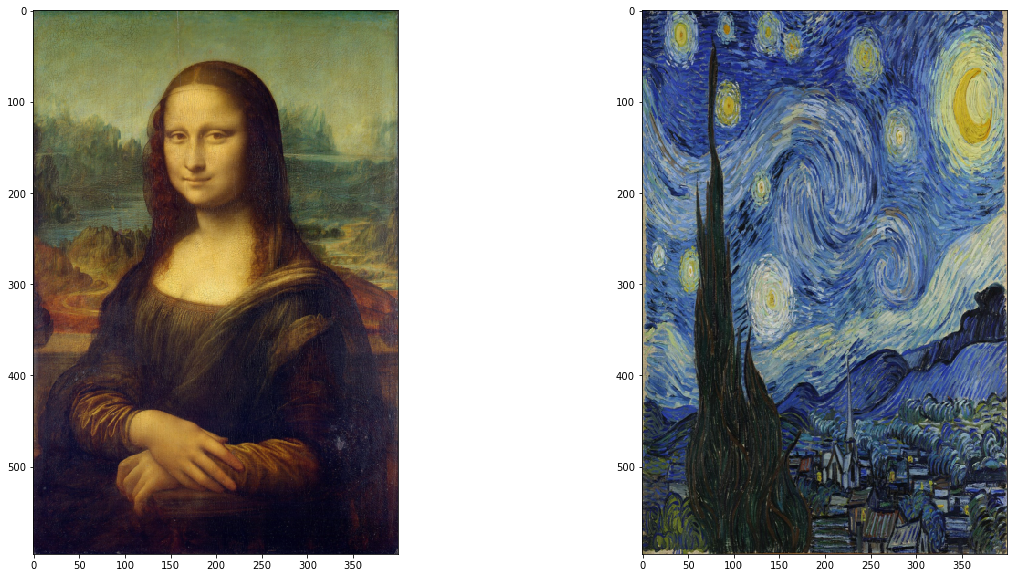

In [65]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [126]:
def get_features(image, model, layers=None):
    modules = list(densenet._modules.items())
    features = {}
    x = image
    if layers is None:
        l1 = modules[0][1] #3 96
        
        l2 = modules[4][1]['denselayer1'].conv1 #96 192
        l3 = modules[4][1]['denselayer1'].conv2 #192 48
        
        l4 = modules[4][1]['denselayer2'].conv1 #240 192
        
        l5 = modules[4][1]['denselayer3'].conv1 #192 192
        
        l6 = modules[6][1]['denselayer1'].conv1 #192 192
        l7 = modules[6][1]['denselayer1'].conv2 #192 48
        
        l8 = modules[6][1]['denselayer2'].conv1 #240 192
        
        l9 = modules[10][1]['denselayer24'].conv2 #192 48
        
        #torch.cat(tensors, dim=0, out=None)
        features['conv0'] = l1(x)
        
        features['1_1_c1'] = l2(features['conv0'])
        features['1_1_c2'] = l3(features['1_1_c1'])
        
        features['1_2_c1'] = l4(torch.cat((features['conv0'], features['1_1_c2']), dim=1))
        
        
        features['1_3_c1'] = l5(features['1_2_c1'])
        
        features['2_1_c1'] = l6(features['1_3_c1'])
        features['2_1_c2'] = l7(features['2_1_c1'])
        
        features['2_2_c1'] = l8(torch.cat((features['2_1_c1'], features['2_1_c2']), dim=1))
        
        features['4_24_c2'] = l9(features['2_2_c1'])
    else:
        l1 = modules[0][1] #3 96
        l2 = modules[4][1]['denselayer1'].conv1 #96 192
        l9 = modules[10][1]['denselayer24'].conv2 #192 48
        
        features['4_24_c2'] = l9(l2(l1(x)))
        
    return features

In [127]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [132]:
# get content and style features only once before training
content_features = get_features(content, densenet)
style_features = get_features(style, densenet)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [133]:
style_weights = {'conv0':1.,
                 '1_1_c1':0.5,
                '1_1_c2':0.5,
                '1_2_c1':0.5,
                 '1_3_c1':0.5,
                '2_1_c1':0.25,
                '2_1_c2':0.25,
                 '2_2_c1':0.1,
                '4_24_c2':0.1}

content_weight = 1 #alpha
style_weight = 1e7 #beta

<h2><b>Train Network</b></h2>


In [134]:
show_every = 1000

optimizer = torch.optim.Adam([target], lr=0.003)
steps = 10000

for ii in range(1, steps+1):
    #get target image features
    target_features = get_features(target, densenet)
    
    #get content loss
    content_loss = torch.mean((target_features['4_24_c2'] - content_features['4_24_c2'])**2)

    #init style loss as 0
    style_loss = 0
    
    #then add to it for each layer's gram matrix loss
    for layer in style_weights:
        #get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _,d,h,w = target_feature.shape
        #get the "style" style representation
        style_gram = style_grams[layer]
        #the style loss for one layer, weighted appropriatly
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        #add to the style loss
        style_loss += layer_style_loss/(d*h*w)
        
    total_loss = content_weight*content_loss + style_weight*style_loss
    
    #update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii%show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

KeyboardInterrupt: 

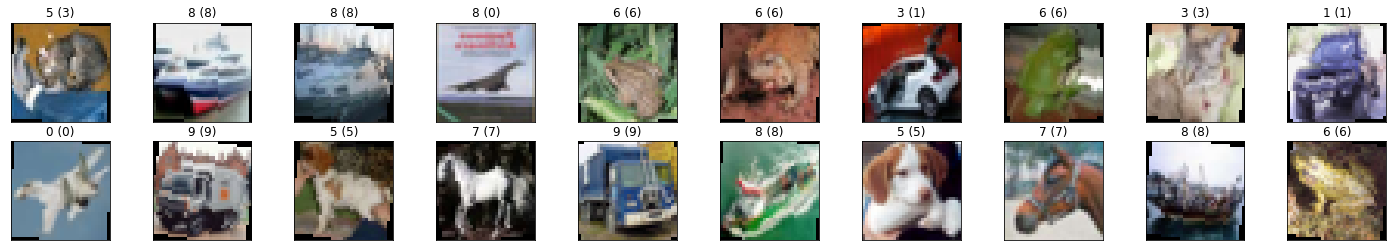

In [70]:
#display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))